In [429]:
import os
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io import sql
import MySQLdb
import pandas.io.sql as psql
import tensorflow as tf
import time
import collections
import datetime
from sqlalchemy import create_engine
import pymysql
from keras.utils import to_categorical

#pip install mysqlclient 
#!pip install -q -U keras-tuner

In [435]:
maus = pd.read_csv("maus_sample.csv")
transactions = pd.read_csv("transactions_sample.csv")

In [409]:
members = pd.read_csv("members_sample.csv")

# Which Device has the most premium members ?

In [352]:
members_premium = members[["deviceOS","premium"]]
members_premium.head()
dum = pd.get_dummies(members_premium)
dum = dum[dum['premium'] == 1]

total = members_premium.premium.sum()
prem_android = dum['deviceOS_android'].sum()
prem_ios = dum['deviceOS_iOS'].sum()
print('Proportion of premium users :')
print('For Android : ',prem_android/total * 100,'%')
print('For IOS : ',prem_ios/total * 100,'%')

Proportion of premium users :
For Android :  41.88940092165899 %
For IOS :  58.11059907834102 %


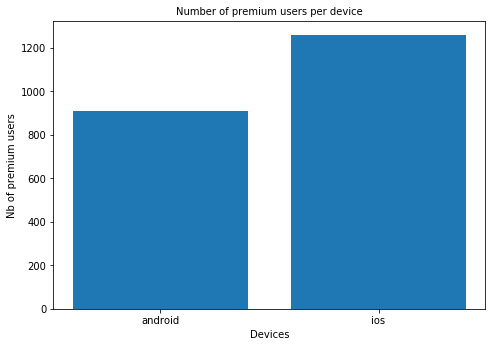

In [347]:
#np.sum(members_premium,axis=1)

prem = [prem_android,prem_ios]
devices = ["android","ios"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylabel('Nb of premium users')
plt.xlabel('Devices');
plt.title('Number of premium users per device', fontsize=10)
ax.bar(devices,prem)

plt.show()

With 1261 premium users, iOS has the largest number of mobile users. 

# Which countries has the oldest members ?

In [81]:
members_country = members[["dobYEAR","ipAddressCountryCode"]]
grp = members_country.groupby(["ipAddressCountryCode"])["dobYEAR"].min()
members_country[members_country.dobYEAR == members_country.dobYEAR.min()]

,dobYEAR,ipAddressCountryCode
2576,1903.0,MA
31317,1903.0,NO
87279,1903.0,US


The countries with the oldest members are MA,NO,US so : Morocco, Norway, United States of America

# Plot the numbers of member by refSource

In [407]:
sources = members.groupby(["refSource"]).count()["memberID"]
refgoogle = members[members['refSource'].str.contains("www.google",na=False)] 
reffb = members[members['refSource'].str.contains("Facebook Ads",na=False)] 
refadwords = members[members['refSource'].str.contains("adwords|AdWords",na=False)] 


#We replace all refsource www.google.xxx by only one google link
lgoogle = list(refgoogle.refSource.unique())
lfb = list(reffb.refSource.unique())
ladw = list(refadwords.refSource.unique())
lsnap = list(refsnap.refSource.unique())

s_ref = 0
s_fb = 0
s_adw = 0
s_org = 0
s_snap = 0

for elem in lgoogle:
    s_ref += sources[elem]
    sources = sources.drop(index=elem)
for elem in lfb:
    s_fb += sources[elem]
    sources = sources.drop(index=elem)
for elem in ladw:
    s_adw += sources[elem]
    sources = sources.drop(index=elem)
for elem in lsnap:
    s_snap += sources[elem]
    sources = sources.drop(index=elem)

""""reforganic = members[members['refSource'].str.contains("organicSearch",na=False)] 
lorga = list(reforganic.refSource.unique())
for elem in lorga:
    s_org += sources[elem]
    sources = sources.drop(index=elem)"""

sources = sources.drop(index='nil')
sources = sources.reset_index()
sources = sources.append({'refSource': 'www.google.com','memberID':s_ref},ignore_index=True)
sources = sources.append({'refSource': 'Facebook Ads','memberID':s_fb},ignore_index=True)
sources = sources.append({'refSource': 'Google Adwords','memberID':s_adw},ignore_index=True)
#sources = sources.append({'refSource': 'Organic Search','memberID':s_org},ignore_index=True)
sources = sources.append({'refSource': 'Snapchat','memberID':s_snap},ignore_index=True)
sources = sources[sources['memberID']>40]
sources.head()

,refSource,memberID
0,(not set),369
1,Apple Search Ads,632
2,Facebook,52
3,Optional(Apple Search Ads),55
6,adperio,168


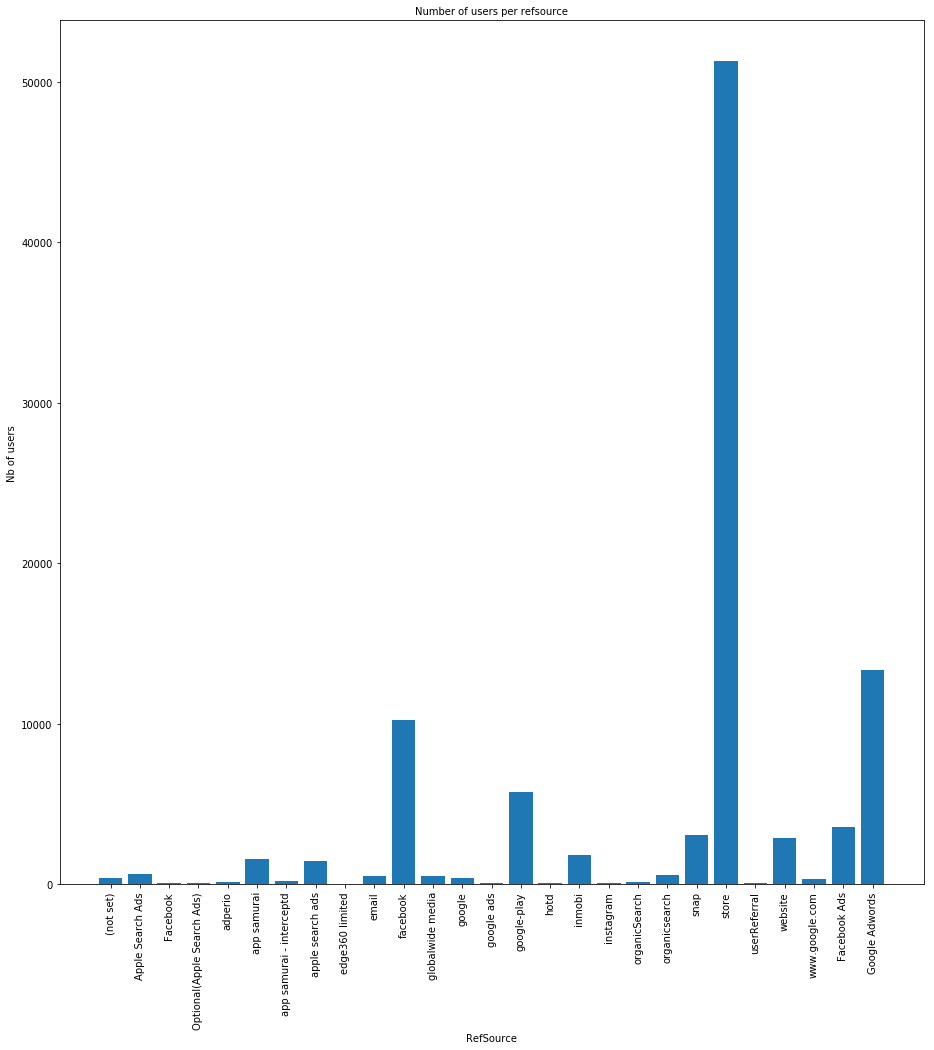

In [384]:
colref = sources.refSource
colcount = sources.memberID

fig = plt.figure()
ax = fig.add_axes([1,1,2,3])
plt.ylabel('Nb of users')
plt.xlabel('RefSource');
plt.xticks(rotation='vertical')
plt.title('Number of users per refsource', fontsize=10)
ax.bar(colref,colcount)

plt.show()

We only keep the refSource with at least 40 members.

# Plot MAUs by gender?

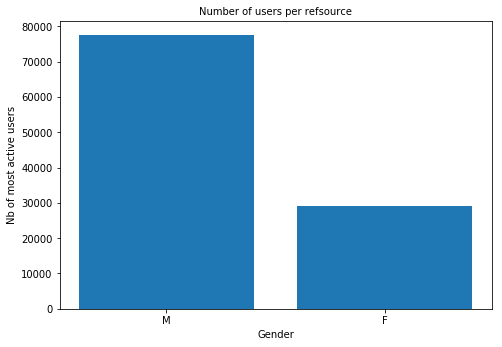

106657
113991


In [388]:
gender = members[['gender','memberID']]
res = pd.merge(maus,gender,how='left',on=['memberID','memberID'])
res = res.drop_duplicates(subset = ["memberID"])
resgender = res['gender'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylabel('Nb of most active users')
plt.xlabel('Gender');
plt.title('Number of users per refsource', fontsize=10)
ax.bar(resgender.index,resgender.values)

plt.show()
print(len(res))
print(len(members))

# Which OS (deviceOS) has the largest number of transactions?

Include not validated and cancelled transaction

In [417]:
transfreq = transactions.groupby(['memberID']).count()
transcount = transfreq[['id']] 
transcount = transcount.rename(columns={"id": "Transactions_count"})
transcount.head()
#transactions.isna().sum()
#transfreq['productID'].sort_values()
#transfreq['productID'].value_counts()
memberstotal = pd.merge(members,transcount,how='left',on=['memberID','memberID'])
memberstotal['Transactions_count'] = memberstotal['Transactions_count'].fillna(0)
memberstotal['Transactions_count'] = memberstotal['Transactions_count'].astype(np.int64)

mt = memberstotal[['deviceOS','Transactions_count']]

tr_iOS = mt[mt['deviceOS'] == 'iOS']
tr_and = mt[mt['deviceOS'] == 'android']
tr_and.Transactions_count.sum()
tr_iOS.Transactions_count.sum()

#This code was used to check the numbers of unvalidated transactions (=159)
"""
transac = transactions[['deviceOS','validated']]
Os = transac.deviceOS
val = transac.validated
transac['validated'].value_counts()
transac_validated = transac[transac.validated != 0]

transac.validated.value_counts()
"""

24067

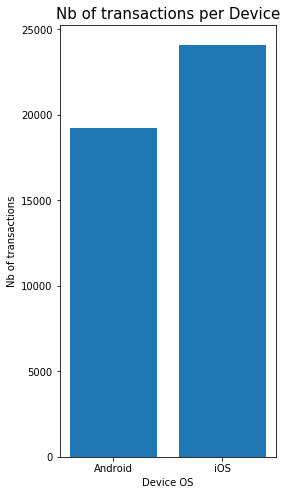

In [426]:
fig = plt.figure()
ax = fig.add_axes([1,1,0.5,1.5])
plt.ylabel('Nb of transactions')
plt.xlabel('Device OS');
plt.title('Nb of transactions per Device', fontsize=15)
ax.bar(['Android','iOS'],[tr_and.Transactions_count.sum(),tr_iOS.Transactions_count.sum()])

plt.show()

Most of the transactions are done by iOS users.

# Data Engineering

### Convert these .csv files into three tables  in a sql database
Next step shoud be to add key constraints for memberID (primary key and foreign key).

In [442]:

dataFrame   = pd.DataFrame(data=members)   
tables =["members","maus","transactions"]
tdata = [members,maus,transactions ]

sqlEngine   = create_engine('mysql+pymysql://root:@127.0.0.1/test', pool_recycle=3600)
dbConnection= sqlEngine.connect()

try:
    for i in range(0,len(tables)):
        frame = tdata[i].to_sql(tables[i], dbConnection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    dbConnection.close()
    
#Warning because of the large size of one receipt 


Table 'members' already exists.


### Export these three tables as a .sql file

They are included in the mail. Data were hosted on MariaDb database.